# Lab 9. Anomaly Detection

**Author:** &nbsp;&nbsp;&nbsp;*Gabriel Szewczyk*</br>
**Date:** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*07.05.2024*

## Anomaly detection algorithm for server computers
The features measure the throughput (mb/s) and latency (ms) of response of each server.

Import data

Amount of records: 307, Number of features: 2


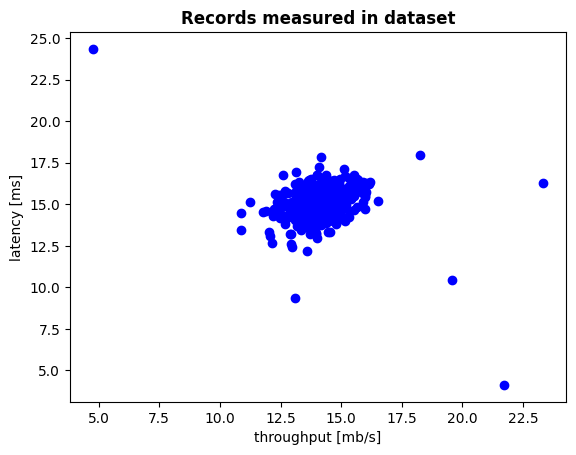

In [18]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  

 
data = loadmat('ex8data1.mat')  
X = data['X']   
print(f"Amount of records: {X.shape[0]}, Number of features: {X.shape[1]}")

plt.scatter(X[:, 0], X[:, 1], c="blue")
plt.xlabel("throughput [mb/s]")
plt.ylabel("latency [ms]")
plt.title("Records measured in dataset", fontweight="bold")
plt.show()

Check wether it is necessary to scale it using histogram

(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   9.,  44., 123.,
         96.,  28.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 4.12623222,  5.13744098,  6.14864973,  7.15985848,  8.17106723,
         9.18227598, 10.19348473, 11.20469348, 12.21590223, 13.22711098,
        14.23831974, 15.24952849, 16.26073724, 17.27194599, 18.28315474,
        19.29436349, 20.30557224, 21.31678099, 22.32798975, 23.3391985 ,
        24.35040725]),
 <BarContainer object of 20 artists>)

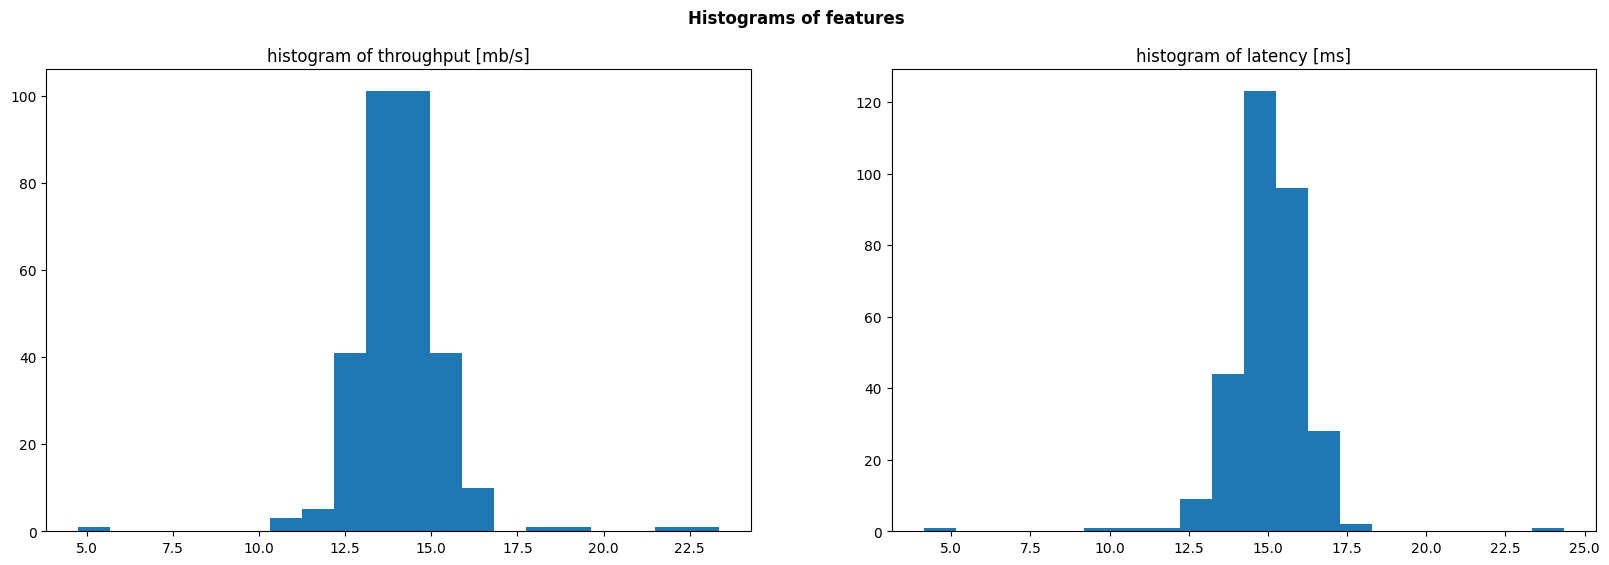

In [19]:
plt.figure(figsize=(20,6))
plt.suptitle("Histograms of features", fontweight="bold")

plt.subplot(1,2,1)
plt.title("histogram of throughput [mb/s]")
plt.hist(X[:, 0], bins=20)

plt.subplot(1,2,2)
plt.title("histogram of latency [ms]")
plt.hist(X[:, 1], bins=20)

## Gaussian distribution

estimate a Gaussian distribution for each feature in the data

In [20]:
from scipy.stats import norm


def estimate_gaussian(data):  
    """calculate parameters for gassian distribution

    Args:
        data (list): array of data

    Returns:
        (Tuple): (mean, standard deviation)
    """
    mu, sigma = norm.fit(data)
    return mu, sigma
troughput = X[:, 0]
latency = X[:, 1]
mu_t, sigma_t = estimate_gaussian(troughput)
print("Latency data distribution: ")
print(f"mu = {mu_t}, sigma = {sigma_t}")

mu_l, sigma_l = estimate_gaussian(latency)
print("Troughput data distribution: ")
print(f"mu = {mu_l}, sigma = {sigma_l}")

Latency data distribution: 
mu = 14.112225783945592, sigma = 1.353747174879607
Troughput data distribution: 
mu = 14.99771050813621, sigma = 1.3075723042450764


Visualize calculated distribution

(3.126232224310076, 25.35040724802435)

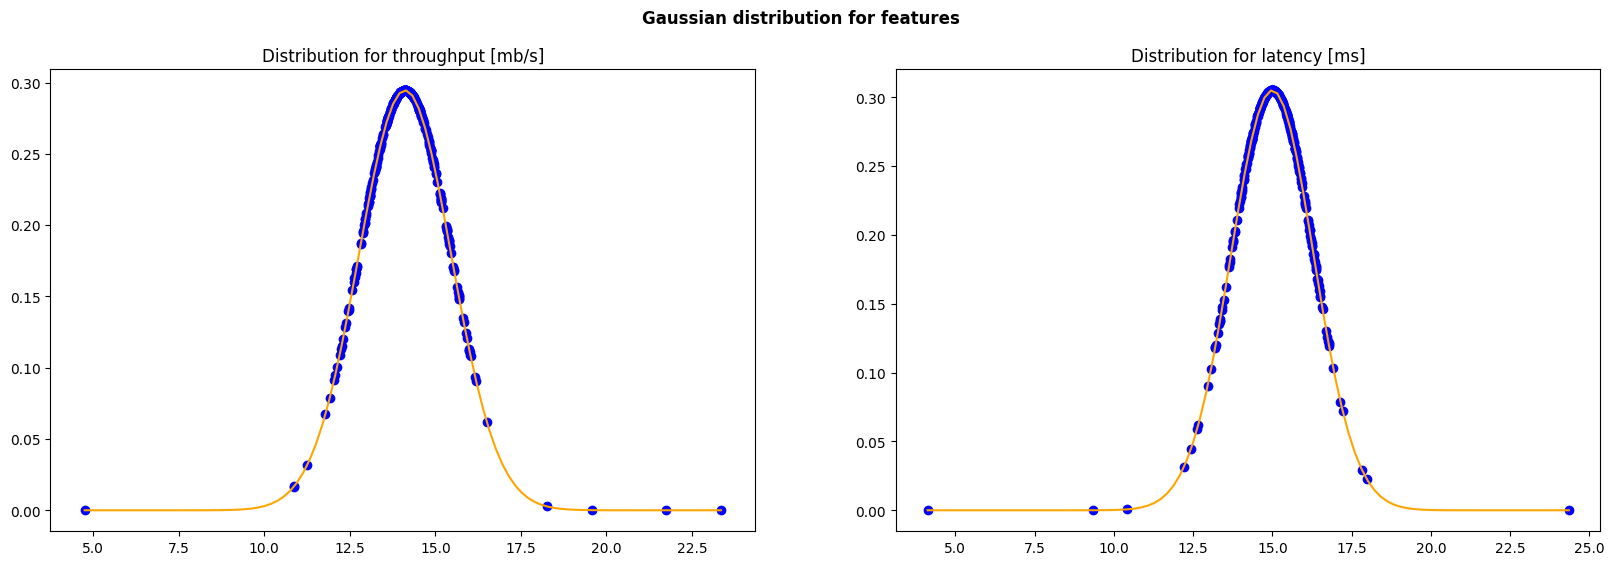

In [21]:
x_t = np.linspace(np.min(troughput), np.max(troughput), 100)
x_l = np.linspace(np.min(latency), np.max(latency), 100)
plt.figure(figsize=(20,6))
plt.suptitle("Gaussian distribution for features", fontweight="bold")

plt.subplot(1,2,1)
plt.title("Distribution for throughput [mb/s]")
plt.plot(x_t, norm.pdf(x_t, mu_t, sigma_t), c='orange')
plt.scatter(troughput, norm.pdf(troughput, mu_t, sigma_t), c="blue")
plt.xlim([np.min(x_t)-1, np.max(x_t)+1])

plt.subplot(1,2,2)
plt.title("Distribution for latency [ms]")
plt.plot(x_l, norm.pdf(x_l, mu_l, sigma_l), c='orange')
plt.scatter(latency, norm.pdf(latency, mu_l, sigma_l), c="blue")
plt.xlim([np.min(x_l)-1, np.max(x_l)+1])

## Select the treshold

Determine a probability threshold which indicates that an example should be considered an anomaly

In [22]:
from scipy import stats

Xval = data['Xval']  
yval = data['yval']

Xval_prob = norm.pdf(Xval, mu_t, sigma_t)


Impement a function that finds the best treshold value given the probability density values and true labels

In [23]:
from sklearn.metrics import f1_score
def select_threshold(pval, yval, iters=1000):
  best_f1 = 0
  best_epsilon = 0
  tresh_spectrum = np.linspace(pval.min(), pval.max(), 10000).tolist()
  for tres in tresh_spectrum:
    anomalies = pval <= tres
    y_pred = np.logical_or(anomalies[:,0],anomalies[:,1])
    f1 = f1_score(yval, y_pred)
    if f1 > best_f1:
      best_f1 = f1
      best_epsilon = tres
  return best_epsilon, best_f1

best_epsilon, best_f1 = select_threshold(Xval_prob, yval, 10000)
print(best_epsilon, best_f1)

0.0004126140087565511 0.875


## Anomaly detection results

Visualize data with pointing out anomalies on the plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


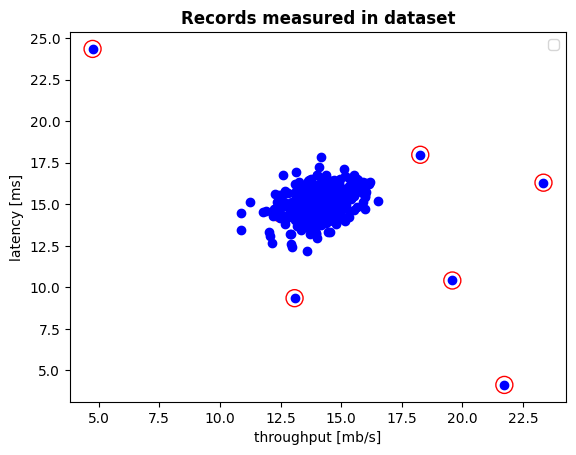

In [24]:
anomalies = Xval_prob < best_epsilon
X_anomalies_conc = np.logical_or(anomalies[:,0], anomalies[:,1])
X_anomalies_indices = np.where(X_anomalies_conc == True)
X_anomalies = X[X_anomalies_indices]

plt.scatter(X_anomalies[:, 0], X_anomalies[:, 1], facecolors='none',edgecolors='r', s=150)
plt.scatter(X[:, 0], X[:, 1], c="blue")
plt.xlabel("throughput [mb/s]")
plt.ylabel("latency [ms]")
plt.title("Records measured in dataset", fontweight="bold")
plt.legend()
plt.show()